<a href="https://colab.research.google.com/github/JIClaveria097/JIClaveria097/blob/main/VaR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Revise el código a continuación y responda las siguientes preguntas:

1. Qué es el VaR y CVaR.
2. Explique los métodos de cálculo del VaR (histórico, paramétrico y montecarlo)
3. Formule un portafolio de su empresa de inversión y calcule los retornos en un rango temporal de 3 años, como en el ejemplo, puede usar yahooFinance como se muestra aquí para extraer los valores y calcular los retornos.
4. Explique por qué escogió dichos activos para el portafolio y que relación tiene con su empresa.
5. Tome un monto de inversión inicial de dicho portafolio, explique el por qué, y calcule el VaR utilizando los métodos:
        - VaR y CVaR histórico.
        - VaR y CVaR montecarlo.
6. Interprete los resultados obtenidos en 5.


In [1]:
### Instalamos las librerías que serán utilizados
!pip install git+https://github.com/pydata/pandas-datareader.git
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from pandas_datareader import data as pdr
from scipy.stats import norm,t

  Cloning https://github.com/pydata/pandas-datareader.git to /tmp/pip-req-build-vdtrw32x
  Running command git clone -q https://github.com/pydata/pandas-datareader.git /tmp/pip-req-build-vdtrw32x
  Created wheel for pandas-datareader: filename=pandas_datareader-0.11.0.dev0+6.gfdade48-py3-none-any.whl size=109747 sha256=91e86dfd9948ef323778b98489939983d71300a4fba4a679b1df4f3f81904d8c
  Stored in directory: /tmp/pip-ephem-wheel-cache-2coilazp/wheels/54/6a/47/b1e68c4877ae6bf9a511e84e13972507e0fac9e17335156eb7
Successfully built pandas-datareader
  Attempting uninstall: pandas-datareader
    Found existing installation: pandas-datareader 0.9.0
    Uninstalling pandas-datareader-0.9.0:
      Successfully uninstalled pandas-datareader-0.9.0


In [2]:
### Primero se define la función que leerá la data, y calculará las estadísticas de retorno y covarianza.
def getData(stocks, start, end):
    stockData = pdr.get_data_yahoo(stocks, start=start, end=end)
    stockData = stockData['Close']
    returns = stockData.pct_change()
    meanReturns = returns.mean()
    covMatrix = returns.cov()
    return returns, meanReturns, covMatrix

In [3]:
### Luego tenemos la función que construirá el portafolio.
def portfolioPerformance(weights, meanReturns, covMatrix, Time):
    returns = np.sum(meanReturns*weights)*Time
    std = np.sqrt( np.dot(weights.T, np.dot(covMatrix, weights)) ) * np.sqrt(Time)
    return returns, std

In [4]:
### Luego definimos los parámetros de los tickers 
### (nemotécnico de los activos que extraerá de yahoo finance, con su fecha inicial y final)
stockList = ['CBA', 'BHP', 'TLS', 'NAB', 'WBC', 'STO']
stocks = [stock+'.AX' for stock in stockList]
endDate = dt.datetime.now()
startDate = endDate - dt.timedelta(days=800)

In [8]:
### Luego aplicamos las funciones recién definidas.
returns, meanReturns, covMatrix = getData(stocks, start=startDate, end=endDate)
returns = returns.dropna()

weights = np.random.random(len(returns.columns))
weights /= np.sum(weights)

returns['portfolio'] = returns.dot(weights)

#print(returns)
#print(covMatrix)
#print(meanReturns)

Symbols
CBA.AX    0.000570
BHP.AX    0.000201
TLS.AX    0.000316
NAB.AX    0.000242
WBC.AX   -0.000253
STO.AX    0.000273
dtype: float64


In [6]:
### Definimos la función que calculará el VaR con un alpha de 5%
def historicalVaR(returns, alpha=5):
    """
    Read in a pandas dataframe of returns / a pandas series of returns
    Output the percentile of the distribution at the given alpha confidence level
    """
    if isinstance(returns, pd.Series):
        return np.percentile(returns, alpha)

    # A passed user-defined-function will be passed a Series for evaluation.
    elif isinstance(returns, pd.DataFrame):
        return returns.aggregate(historicalVaR, alpha=alpha)

    else:
        raise TypeError("Expected returns to be dataframe or series")
 

In [9]:
### Definimos la función que calculará el CVaR con un alpha de 5%
def historicalCVaR(returns, alpha=5):
    """
    Read in a pandas dataframe of returns / a pandas series of returns
    Output the CVaR for dataframe / series
    """
    if isinstance(returns, pd.Series):
        belowVaR = returns <= historicalVaR(returns, alpha=alpha)
        return returns[belowVaR].mean()

    # A passed user-defined-function will be passed a Series for evaluation.
    elif isinstance(returns, pd.DataFrame):
        return returns.aggregate(historicalCVaR, alpha=alpha)

    else:
        raise TypeError("Expected returns to be dataframe or series")

In [10]:
### Mostramos resultados de VaR y CVaR histórico
print(historicalVaR(returns,alpha=5))
print(historicalCVaR(returns,alpha=5))
print(historicalVaR(returns["portfolio"],alpha=5))
print(historicalCVaR(returns["portfolio"],alpha=5))

Symbols
CBA.AX      -0.025024
BHP.AX      -0.029350
TLS.AX      -0.020761
NAB.AX      -0.025908
WBC.AX      -0.028086
STO.AX      -0.035741
portfolio   -0.023563
dtype: float64
Symbols
CBA.AX      -0.046733
BHP.AX      -0.047045
TLS.AX      -0.033994
NAB.AX      -0.051901
WBC.AX      -0.053846
STO.AX      -0.068109
portfolio   -0.044538
dtype: float64
-0.02356278394982568
-0.04453752171295875


In [ ]:
### Se calcula el VaR y CVaR a 1 día, con una inversión inicial de 1000000

#1 day
Time=1

VaR = historicalVaR(returns["portfolio"],alpha=5)
CVaR = historicalCVaR(returns["portfolio"],alpha=5)
pRet, pStd = portfolioPerformance(weights, meanReturns, covMatrix, Time)


# Si se tiene una inversión de ...
InitialInvestment = 1000000
print("Expect Portfolio Return: ", round(InitialInvestment*pRet,2))
print("Value at Risk 95th CI: ", round(InitialInvestment*VaR,2))
print("Conditional Value at Risk 95th CI: ", round(InitialInvestment*CVaR,2))

Expect Portfolio Return:  327.31
Value at Risk 95th CI:  -23621.71
Conditional Value at Risk 95th CI:  -41106.87


In [ ]:
### Se define la función para calcular el VaR paramétrico
def var_parametric(portofolioReturns, portfolioStd, distribution='normal', alpha=5, dof=6):
    # because the distribution is symmetric
    if distribution == 'normal':
        VaR = norm.ppf(1-alpha/100)*portfolioStd - portofolioReturns
    elif distribution == 't-distribution':
        nu = dof
        VaR = np.sqrt((nu-2)/nu) * t.ppf(1-alpha/100, nu) * portfolioStd - portofolioReturns
    else:
        raise TypeError("Expected distribution type 'normal'/'t-distribution'")
    return VaR

In [ ]:
### Se define la función para calcular el CVaR paramétrico
def cvar_parametric(portofolioReturns, portfolioStd, distribution='normal', alpha=5, dof=6):
    if distribution == 'normal':
        CVaR = (alpha/100)**-1 * norm.pdf(norm.ppf(alpha/100))*portfolioStd - portofolioReturns
    elif distribution == 't-distribution':
        nu = dof
        xanu = t.ppf(alpha/100, nu)
        CVaR = -1/(alpha/100) * (1-nu)**(-1) * (nu-2+xanu**2) * t.pdf(xanu, nu) * portfolioStd - portofolioReturns
    else:
        raise TypeError("Expected distribution type 'normal'/'t-distribution'")
    return CVaR

In [ ]:
### Se calcula el VaR, CVaR y distribuciones t paramétricos, con la misma inversión anterior.
normVar = var_parametric(pRet, pStd)
normCVar = cvar_parametric(pRet, pStd)

tVar = var_parametric(pRet, pStd, distribution="t-distribution")
tCVar = cvar_parametric(pRet, pStd, distribution="t-distribution")


print("normal VaR 95th CI: ", round(InitialInvestment*normVar,2))
print("normal CVaR 95th CI: ", round(InitialInvestment*normCVar,2))

print("t-dist VaR 95th CI: ", round(InitialInvestment*tVar,2))
print("t-dist CVaR 95th CI: ", round(InitialInvestment*tCVar,2))

normal VaR 95th CI:  28050.21
normal CVaR 95th CI:  35259.24
t-dist VaR 95th CI:  27045.2
t-dist CVaR 95th CI:  36871.52


### MONTECARLO

In [ ]:
# Monte Carlo Method
mc_sims = 400 # number of simulations
T = 100 #timeframe in days

meanM = np.full(shape=(T, len(weights)), fill_value=meanReturns)
meanM = meanM.T

portfolio_sims = np.full(shape=(T, mc_sims), fill_value=0.0)

initialPortfolio = 1000000

for m in range(0, mc_sims):
    # MC loops
    Z = np.random.normal(size=(T, len(weights)))
    L = np.linalg.cholesky(covMatrix)
    dailyReturns = meanM + np.inner(L, Z)
    portfolio_sims[:,m] = np.cumprod(np.inner(weights, dailyReturns.T)+1)*initialPortfolio


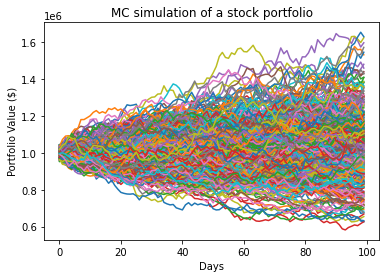

In [ ]:
### Se grafica la simulación!
plt.plot(portfolio_sims)
plt.ylabel('Portfolio Value ($)')
plt.xlabel('Days')
plt.title('MC simulation of a stock portfolio')
plt.show()

In [ ]:
### Se define las funciones que calcularán la simulación montecarlo de VaR y CVar
def mcVaR(returns, alpha=5):
    """ Input: pandas series of returns
        Output: percentile on return distribution to a given confidence level alpha
    """
    if isinstance(returns, pd.Series):
        return np.percentile(returns, alpha)
    else:
        raise TypeError("Expected a pandas data series.")

def mcCVaR(returns, alpha=5):
    """ Input: pandas series of returns
        Output: CVaR or Expected Shortfall to a given confidence level alpha
    """
    if isinstance(returns, pd.Series):
        belowVaR = returns <= mcVaR(returns, alpha=alpha)
        return returns[belowVaR].mean()
    else:
        raise TypeError("Expected a pandas data series.")

In [ ]:
### Se muestran los resultados
portResults = pd.Series(portfolio_sims[-1,:])

VaR = initialPortfolio - mcVaR(portResults, alpha=5)
CVaR = initialPortfolio - mcCVaR(portResults, alpha=5)

print('VaR ${}'.format(round(VaR,2)))
print('CVaR ${}'.format(round(CVaR,2)))

VaR $251776.15
CVaR $304186.44
